# CS6700 : Tutorial 1 - Multi-Arm Bandits

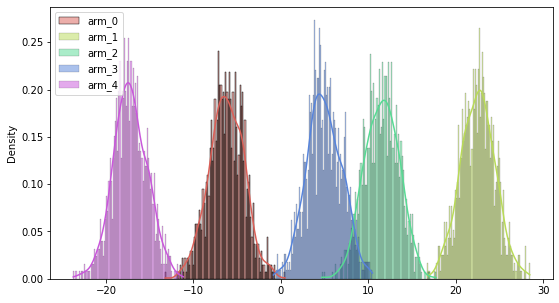

        Goal: Analysis 3 types of sampling strategy in a MAB

### Import dependencies

In [1]:
# !pip install seaborn

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import NamedTuple, List

### Gaussian Bandit Environment

In [2]:
class GaussianArm(NamedTuple):
  mean: float
  std: float


class Env:
  def __init__(self, num_arms: int, mean_reward_range: tuple, std: float):
    """
    num_arms: number of bandit arms
    mean_reward_range: mean reward of an arm should lie between the given range
    std: standard deviation of the reward for each arm
    """
    self.num_arms = num_arms
    self.arms = self.create_arms(num_arms, mean_reward_range, std)
  
  def create_arms(self, n: int, mean_reward_range: tuple, std: float) -> dict:
    low_rwd, high_rwd = mean_reward_range
    # creates "n" number of mean reward for each arm
    means = np.random.uniform(low=low_rwd, high=high_rwd, size=(n,))
    arms = {id: GaussianArm(mu, std) for id, mu in enumerate(means)}
    return arms

  @property
  def arm_ids(self):
    return list(self.arms.keys())

  def step(self, arm_id: int) -> float:
    arm = self.arms[arm_id]
    return np.random.normal(arm.mean, arm.std)   # Reward

  def get_best_arm_and_expected_reward(self):
    best_arm_id = max(self.arms, key=lambda x: self.arms[x].mean)
    return best_arm_id, self.arms[best_arm_id].mean

  def get_avg_arm_reward(self):
    arm_mean_rewards = [v.mean for v in self.arms.values()]
    return np.mean(arm_mean_rewards)

  def plot_arms_reward_distribution(self, num_samples=1000):
    """
    This function is only used to visualize the arm's distrbution.
    """
    fig, ax = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(9, 5))
    colors = sns.color_palette("hls", self.num_arms)
    for i, arm_id in enumerate(self.arm_ids):
      reward_samples = [self.step(arm_id) for _ in range(num_samples)]
      sns.histplot(reward_samples, ax=ax, stat="density", kde=True, bins=100, color=colors[i], label=f'arm_{arm_id}')
    ax.legend()
    plt.show()

### Policy

In [3]:
class BasePolicy:
  @property
  def name(self):
    return 'base_policy'

  def reset(self):
    """
    This function resets the internal variable.
    """
    pass

  def update_arm(self, *args):
    """
    This function keep track of the estimates 
    that we may want to update during training.
    """
    pass

  def select_arm(self) -> int:
    """
    It returns arm_id
    """
    raise Exception("Not Implemented")

#### Random Policy

In [4]:
class RandomPolicy(BasePolicy):
  def __init__(self, arm_ids: List[int]):
    self.arm_ids = arm_ids

  @property
  def name(self):
    return 'random'

  def reset(self) -> None:
    """No use."""
    pass

  def update_arm(self, *args) -> None:
    """No use."""
    pass

  def select_arm(self) -> int:
    return np.random.choice(self.arm_ids)

#### Epsilon-greedy

In [5]:
class EpGreedyPolicy(BasePolicy):
  def __init__(self, epsilon: float, arm_ids: List[int]):
    self.epsilon = epsilon
    self.arm_ids = arm_ids
    self.Q = {id: 0 for id in self.arm_ids}
    self.num_pulls_per_arm = {id: 0 for id in self.arm_ids}

  @property
  def name(self):
    return f'ep-greedy ep:{self.epsilon}'

  def reset(self) -> None:
    self.Q = {id: 0 for id in self.arm_ids}
    self.num_pulls_per_arm = {id: 0 for id in self.arm_ids}

  def update_arm(self, arm_id: int, arm_reward: float) -> None:
    # your code for updating the Q values of each arm
    self.num_pulls_per_arm[arm_id] += 1 if arm_id in self.arm_ids else 0
    self.Q[arm_id] = (1 - 1.0/ self.num_pulls_per_arm[arm_id])*self.Q[arm_id] + 1/self.num_pulls_per_arm[arm_id] * arm_reward 

  def select_arm(self) -> int:
    # your code for selecting arm based on epsilon greedy policy
    return np.random.choice(self.arm_ids) if np.random.random() < self.epsilon else max(self.Q, key=self.Q.get)

#### Softmax

In [6]:
class SoftmaxPolicy(BasePolicy):
  def __init__(self, tau, arm_ids):
    self.tau = tau
    self.arm_ids = arm_ids
    self.Q = {id: 0 for id in self.arm_ids}
    self.num_pulls_per_arm = {id: 0 for id in self.arm_ids}

  @property
  def name(self):
    return f'softmax tau:{self.tau}'
  
  def reset(self):
    self.Q = {id: 0 for id in self.arm_ids}
    self.num_pulls_per_arm = {id: 0 for id in self.arm_ids}

  def update_arm(self, arm_id: int, arm_reward: float) -> None:
    # your code for updating the Q values of each arm
    self.num_pulls_per_arm[arm_id] += 1 if arm_id in self.arm_ids else 0
    self.Q[arm_id] = (1 - 1.0/ self.num_pulls_per_arm[arm_id])*self.Q[arm_id] + 1/self.num_pulls_per_arm[arm_id] * arm_reward 

  def softmax(self, q_values: List[float]):
    q_values_array = np.array(q_values, dtype=float)

    # Shift values for numerical stability
    shifted_q_values = q_values_array - np.max(q_values_array)

    # Calculate softmax probabilities
    softmax_probabilities = np.exp(shifted_q_values / self.tau) / np.sum(np.exp(shifted_q_values / self.tau))

    return softmax_probabilities
  
  def select_arm(self) -> int:
    # your code for selecting arm based on softmax policy
    return np.random.choice(self.arm_ids, p=self.softmax(list(self.Q.values())))

#### UCB

In [7]:
class UCB(BasePolicy):
  # your code here
  def __init__(self, arm_ids):
    self.c = np.sqrt(2)
    self.arm_ids = arm_ids
    self.Q = {id: 0 for id in self.arm_ids}
    self.num_pulls_per_arm = {id: 0 for id in self.arm_ids}
    self.inital_pulls_done = False

  @property
  def name(self):
    return f'UCB'
  
  def reset(self):
    self.Q = {id: 0 for id in self.arm_ids}
    self.num_pulls_per_arm = {id: 0 for id in self.arm_ids}
    self.inital_pulls_done = False 

  def update_arm(self, arm_id: int, arm_reward: float) -> None:
    # your code for updating the Q values of each arm
    self.num_pulls_per_arm[arm_id] += 1 if arm_id in self.arm_ids else 0
    self.inital_pulls_done = all(count > 0 for count in self.num_pulls_per_arm.values())
    self.Q[arm_id] = (1 - 1.0/ self.num_pulls_per_arm[arm_id])*self.Q[arm_id] + 1/self.num_pulls_per_arm[arm_id] * arm_reward 
  
  def ucb(self, arm_id: int) -> float:
    return float('inf') if self.num_pulls_per_arm[arm_id] == 0 \
      else self.Q[arm_id] + self.c * np.sqrt(np.log(sum(self.num_pulls_per_arm.values())) / self.num_pulls_per_arm[arm_id])
  
  def select_arm(self) -> int:
    # your code for selecting arm based on UCB
    return min(self.arm_ids, key=lambda arm_id: self.num_pulls_per_arm[arm_id]) if not self.inital_pulls_done else max(self.arm_ids, key=self.ucb)


#### Trainer

In [8]:
def train(env, policy: BasePolicy, timesteps):
  policy_reward = np.zeros((timesteps,))
  for t in range(timesteps):
    arm_id = policy.select_arm()
    reward = env.step(arm_id)
    policy.update_arm(arm_id, reward)
    policy_reward[t] = reward
  return policy_reward 


def avg_over_runs(env, policy: BasePolicy, timesteps, num_runs):
  _, expected_max_reward = env.get_best_arm_and_expected_reward()
  policy_reward_each_run = np.zeros((num_runs, timesteps))
  for run in range(num_runs):
    policy.reset()
    policy_reward = train(env, policy, timesteps)
    policy_reward_each_run[run, :] = policy_reward

  # calculate avg policy reward from policy_reward_each_run
  avg_policy_rewards = np.mean(policy_reward_each_run, axis=0) # your code here (type: nd.array, shape: (timesteps,))
  total_policy_regret = timesteps * expected_max_reward - np.sum(avg_policy_rewards) # your code here (type: float)

  return avg_policy_rewards, total_policy_regret

In [9]:
def plot_reward_curve_and_print_regret(env, policies, timesteps=200, num_runs=500):
  fig, ax = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(10, 6))
  for policy in policies:
    avg_policy_rewards, total_policy_regret = avg_over_runs(env, policy, timesteps, num_runs)
    print('regret for {}: {:.3f}'.format(policy.name, total_policy_regret))
    ax.plot(np.arange(timesteps), avg_policy_rewards, '-', label=policy.name)
  
  _, expected_max_reward = env.get_best_arm_and_expected_reward()
  ax.plot(np.arange(timesteps), [expected_max_reward]*timesteps, 'g-')
  
  avg_arm_reward = env.get_avg_arm_reward()
  ax.plot(np.arange(timesteps), [avg_arm_reward]*timesteps, 'r-')

  plt.legend(loc='lower right')
  plt.show()

### Experiments

In [10]:
seed = 42
np.random.seed(seed)

num_arms = 5
mean_reward_range = (-25, 25)
std = 2.0

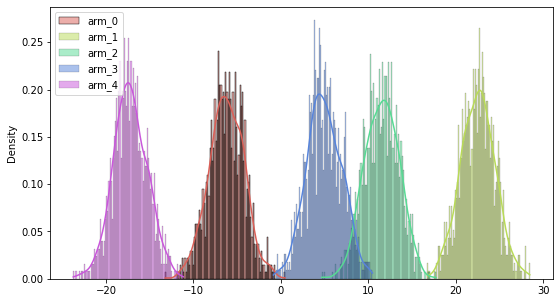

In [11]:
env = Env(num_arms, mean_reward_range, std)

env.plot_arms_reward_distribution()

In [12]:
best_arm, max_mean_reward = env.get_best_arm_and_expected_reward()
print(best_arm, max_mean_reward)

1 22.53571532049581


In [13]:
print(env.get_avg_arm_reward())

3.119254917081568


#### Please explore following values:

- Epsilon greedy: [0.001, 0.01, 0.5, 0.9]
- Softmax: [0.001, 1.0, 5.0, 50.0]

regret for random: 3871.625


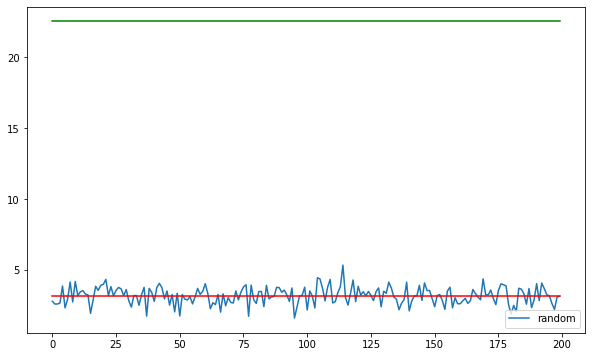

In [14]:
random_policy = RandomPolicy(env.arm_ids)
plot_reward_curve_and_print_regret(env, [random_policy], timesteps=200, num_runs=500)

regret for ep-greedy ep:0.001: 39.590
regret for ep-greedy ep:0.01: 83.511
regret for ep-greedy ep:0.5: 1980.353
regret for ep-greedy ep:0.9: 3505.350


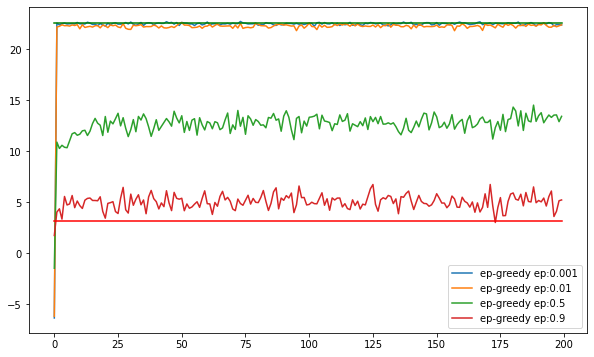

In [15]:
explore_epgreedy_epsilons =  [0.001, 0.01, 0.5, 0.9]
epgreedy_policies = [EpGreedyPolicy(ep, env.arm_ids) for ep in explore_epgreedy_epsilons]
plot_reward_curve_and_print_regret(env, epgreedy_policies, timesteps=200, num_runs=500)

regret for softmax tau:0.001: 1922.557
regret for softmax tau:1.0: 1344.711
regret for softmax tau:5.0: 411.401
regret for softmax tau:50.0: 3150.510


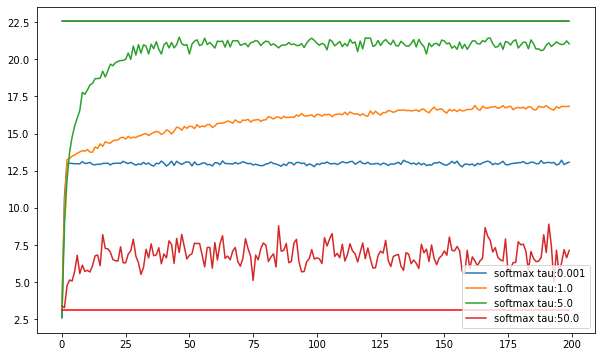

In [16]:
explore_softmax_taus =  [0.001, 1.0, 5.0, 50.0]
softmax_polices = [SoftmaxPolicy(tau, env.arm_ids) for tau in explore_softmax_taus]
plot_reward_curve_and_print_regret(env, softmax_polices, timesteps=200, num_runs=500)

regret for UCB: 95.406


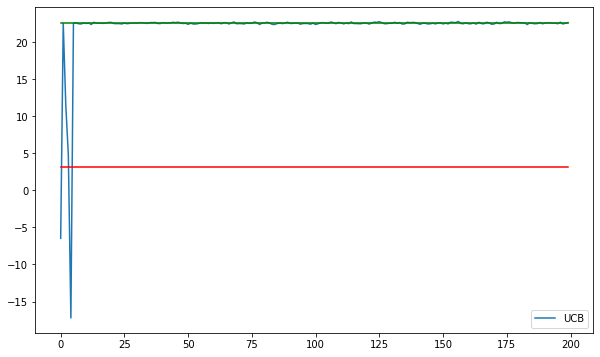

In [17]:
plot_reward_curve_and_print_regret(env, [UCB(env.arm_ids)], timesteps=200, num_runs=500)

#### Optional: Please explore different values of epsilon, tau and verify how does the behaviour changes.

<b>Epsilon-greedy algorithm:</b> The smaller the value of epsilon, the more the algorithm will choose the arm with highest empirical mean. In other words, the epsilon-greedy algorithm's behavior changes as we change the value of epsilon, with lower values focusing more on exploitation and higher values focusing more on exploration. The optimum value of epsilon requires the prior knowledge of sub-optimality gaps. The algorithms becomes random policy as epsilon goes to 1 and hence for fixed time horizon usually very high value of epsilon suffers high regret. As the epsilon becomes 0, it will focus on exploiting the best action it has found so far, but it may miss out on discovering better actions if they are not initially chosen.

<b>Softmax algorithm:</b> The behavior of the softmax function changes as we adjust the value of tau:
<ol>
<li> <i>High temperatures (tau approaches infinity):</i> In this case, all actions have nearly the same probability, and the algorithm tends to explore more.</li>
<li> <i>Low temperatures (tau approaches 0):</i> The probability of the action with the highest expected reward tends to 1, and the algorithm focuses more on exploiting the best arm so far and may suffer premature exploitation.</li>
</ol>

<b>UCB:</b>


<p><i>Core Idea:</i> UCB balances exploration and exploitation using upper confidence bounds, favoring actions with high potential rewards and uncertainty.</p>

<p><i>Adaptability:</i> UCB adjusts strategies over time, refining estimates and transitioning from exploration to exploitation.</p>

<p><i>Robustness:</i> Suited for dynamic environments, UCB actively explores uncertain options to discover hidden opportunities.</p>

<p><i>Optimism:</i> UCB's principle is optimism, expressing confidence that exploring uncertainties will lead to superior long-term rewards.</p>


<b>Summary: </b> Here is a comparison between all the three algorithms discussed:


<b>Epsilon-Greedy:</b>
<ol>
<li><i>Strategy:</i> Selects the arm with the highest expected reward with probability 1-epsilon and selects a random arm with probability epsilon.</li>
<li><i>Strengths:</i> Simple to implement and computationally efficient. It strikes a balance between exploration and exploitation.</li>
<li><i>Weaknesses:</i> May require fine-tuning of the epsilon parameter. Can be inefficient in scenarios with changing reward distributions.</li>
</ol>

<b>Softmax:</b>
<ol>
<li><i>Strategy:</i> Selects arms with probabilities proportional to their expected rewards, controlled by a temperature parameter tau.</li>
<li><i>Strengths:</i> Adaptable to changes in the environment. Provides a smooth transition from exploration to exploitation as the temperature parameter changes.</li>
<li><i>Weaknesses:</i> The choice of the temperature parameter tau can significantly impact performance and may require careful tuning. It may not perform well in scenarios with high-variance settings.</li>
</ol>

<b>UCB (Upper Confidence Bound):</b>
<ol>
<li><i>Strategy:</i> Selects the arm with the highest upper confidence bound, balancing exploration and exploitation by favoring arms with high uncertainty or high expected reward.</li>
<li><i>Strengths:</i> Fast learner and can recover quickly from changes in the environment. Performs well on problems with small and medium numbers of arms and high-variance settings.</li>
<li><i>Weaknesses:</i> May be sensitive to the number of arms and the reward variance. The performance can deteriorate when the number of arms becomes large.</li>
</ol>